In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import pathlib
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [ ]:
#PATH = '/content/drive/My Drive/Colab Notebooks/projects/race_cars/data/068_001_-003_Tex_19_R_AR045.txt'
PATH = '/content/drive/My Drive/race_cars_raghu/data/068_001_-003_Tex_19_R_AR045.txt'

In [ ]:
df = pd.read_csv(PATH, delimiter = "\t")

In [ ]:
df.head()

In [ ]:
training_set_fl = df.loc[:,'LoadFL']

training_set_fl[:5]

0    395.268293
1    411.758902
2    396.903811
3    418.232807
4    398.130436
Name: LoadFL, dtype: float64

In [ ]:
sc = MinMaxScaler()
training_data_fl = sc.fit_transform(training_set_fl.values.reshape(-1, 1))

In [ ]:
class UniVariantTimeSeriesDataset(Dataset):
  def __init__(self, data, input_window = 120, output_window = 6, 
               train_data = True, split=0.7):
    self.data = data
    self.data_len = len(self.data)

    # split train and test data based on the given param
    self.data = self.data[: int(self.data_len * split)] if train_data else self.data[int(self.data_len * split): ]
    self.data_len = len(self.data)

    # convert to tensor
    self.data = torch.tensor(self.data, dtype=torch.float32)

    self.input_window = input_window
    self.output_window = output_window
    print(f"total data length: {self.data_len}")
  
  def __len__(self):
    return self.data_len - self.input_window - self.output_window + 1

  def __getitem__(self, idx):
    assert idx + self.input_window + self.output_window <= self.data_len
    x = self.data[idx: idx + self.input_window]
    y = self.data[idx + self.input_window: idx + self.input_window + self.output_window]

    return x, torch.squeeze(y)


In [ ]:
INPUT_WINDOW=1200
OUTPUT_WINDOW=600
BATCH_SIZE=512
train_fl_dataset_1outputstep = UniVariantTimeSeriesDataset(training_data_fl, INPUT_WINDOW, OUTPUT_WINDOW)
test_fl_dataset_1outputstep = UniVariantTimeSeriesDataset(training_data_fl, INPUT_WINDOW, OUTPUT_WINDOW, train_data=False)

total data length: 504979
total data length: 216421


In [ ]:
train_fl_dataloader_1outputstep = DataLoader(train_fl_dataset_1outputstep, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_fl_dataloader_1outputstep = DataLoader(test_fl_dataset_1outputstep, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

In [ ]:
for batch in test_fl_dataloader_1outputstep:
  print(f"X shape: {batch[0].shape}")
  print(f"Y shape: {batch[1].shape}")
  # print(batch[0])
  # print(batch[1])
  break

X shape: torch.Size([512, 1200, 1])
Y shape: torch.Size([512, 600])


In [ ]:
class MultilayerLSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(MultilayerLSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
            
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc1 = nn.Linear(2*hidden_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.do1 = nn.Dropout(0.25)

        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        # h_0 = Variable(torch.zeros(
        #     self.num_layers, x.size(0), self.hidden_size))
        
        # c_0 = Variable(torch.zeros(
        #     self.num_layers, x.size(0), self.hidden_size).cuda())
        
        # Propagate input through LSTM
        out, (h_out, _) = self.lstm(x)

        out = torch.cat((h_out[-1], out[:, -1, :]), dim=1)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.do1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out

In [ ]:
learning_rate = 0.001

input_size = 1
hidden_size = 128
num_layers = 6

num_classes = OUTPUT_WINDOW


multilayer_lstm = MultilayerLSTM(num_classes, input_size, hidden_size, num_layers, INPUT_WINDOW)

criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(multilayer_lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(multilayer_lstm.parameters(), lr=learning_rate, momentum=0.9)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=2, factor =0.5 ,min_lr=1e-7, verbose=True)
multilayer_lstm.cuda()

MultilayerLSTM(
  (lstm): LSTM(1, 128, num_layers=6, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do1): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=600, bias=True)
)

In [ ]:
num_epochs = 200
train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)
best_loss = 1
num_train_batches = len(train_fl_dataloader_1outputstep)
num_test_batches = len(test_fl_dataloader_1outputstep)
model_save_path = '/content/drive/My Drive/race_cars_raghu/models/multilayer_layer_lstm'


# Train the model
for epoch in range(num_epochs):
  running_loss=0.0
  multilayer_lstm.train()
  for i, data in enumerate(train_fl_dataloader_1outputstep):
    # with torch.autograd.set_detect_anomaly(True):
    inputs, labels = data[0].cuda(), data[1].cuda()


    outputs = multilayer_lstm(inputs)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, labels)
    
    loss.backward()
    
    optimizer.step()

    running_loss += loss.item()

  running_loss /= num_train_batches
  print("Epoch: %d, train loss: %1.5f" % (epoch, running_loss))
  train_hist[epoch] = running_loss

  ## Evaluate and save the best model
  running_loss=0.0
  multilayer_lstm.eval()
  for i, data in enumerate(test_fl_dataloader_1outputstep):

    inputs, labels = data[0].cuda(), data[1].cuda()
    outputs = multilayer_lstm(inputs)

    # obtain the loss function
    loss = criterion(outputs, labels)
    running_loss += loss.item()

  running_loss /= num_train_batches
  scheduler.step(running_loss)

  if running_loss < best_loss:
    print(f"saving the model as {running_loss} is better than {best_loss}")
    torch.save(multilayer_lstm, model_save_path)
    best_loss = running_loss

  print("Epoch: %d, test loss: %1.5f" % (epoch, running_loss))
  test_hist[epoch] = running_loss


Epoch: 0, train loss: 0.07466
saving the model as 0.4750138993544593 is better than 1
Epoch: 0, test loss: 0.47501
Epoch: 1, train loss: 0.07381
Epoch: 1, test loss: 0.65694
Epoch: 2, train loss: 0.07333
Epoch     4: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 2, test loss: 0.51797
Epoch: 3, train loss: 0.07289
saving the model as 0.12332793995965412 is better than 0.4750138993544593
Epoch: 3, test loss: 0.12333
Epoch: 4, train loss: 0.07282
saving the model as 0.05843803726917366 is better than 0.12332793995965412
Epoch: 4, test loss: 0.05844
Epoch: 5, train loss: 0.07267
saving the model as 0.03457006556289848 is better than 0.05843803726917366
Epoch: 5, test loss: 0.03457
Epoch: 6, train loss: 0.07258
Epoch: 6, test loss: 0.07001
Epoch: 7, train loss: 0.07246
Epoch: 7, test loss: 0.06799
Epoch: 8, train loss: 0.07236
Epoch    10: reducing learning rate of group 0 to 2.5000e-04.
Epoch: 8, test loss: 0.11169
Epoch: 9, train loss: 0.07235
Epoch: 9, test loss: 0.03545
Epoch:

In [ ]:
multilayer_lstm = torch.load('/content/drive/My Drive/race_cars_raghu/models/multilayer_layer_lstm_raghu1')

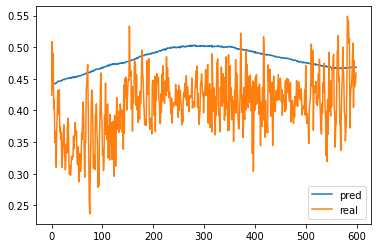

In [ ]:
test_dataset = test_fl_dataset_1outputstep[1]
# test_dataset[0].unsqueeze(0).shape# # print(one_img.unsqueeze(0))
multilayer_lstm.eval()
outputs = multilayer_lstm(test_dataset[0].unsqueeze(0).cuda())

# print(outputs.shape)
plt.plot(np.squeeze(outputs.cpu().detach().numpy()),label='predict_fr')
plt.plot(test_dataset[1].numpy(), label='real_fr')
plt.legend(['pred', 'real'])

In [ ]:
def get_predictions(model, dataset, output_window):
  data_len = len(dataset)
  n_steps = data_len//output_window
  predictions = []
  actual = []
  for i in range(n_steps):
    data_chunk = dataset[i*output_window]
    actual += list(data_chunk[1])
    output = model(data_chunk[0].unsqueeze(0).cuda())
    predictions += list(np.squeeze(output.cpu().detach().numpy()))

  return predictions, actual

In [ ]:
preds, actual = get_predictions(multilayer_lstm, test_fl_dataset_1outputstep, 600)

In [ ]:
preds = sc.inverse_transform(np.array(preds).reshape(1, -1))
actual = sc.inverse_transform(np.array(actual).reshape(1, -1))

In [ ]:
preds = np.squeeze(preds)
actual = np.squeeze(actual)

In [ ]:
plt.figure(figsize=(35, 7))
plt.plot(actual[:61200])
plt.plot(preds[:61200])

plt.legend(['actual', 'preds'])